In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Union, Tuple
import copy
from scipy.stats import multivariate_normal
from types import SimpleNamespace
import math
import os
ROOT_DIRECTORY = os.path.abspath('')
os.chdir(ROOT_DIRECTORY)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from das.smc_utils import compute_ess_from_log_w, normalize_log_weights, resampling_function, normalize_weights, adaptive_tempering
 
import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


In [42]:

rare_prob = 0.00001 


def compute_reward(x, k=10):
    if isinstance(x, torch.Tensor):
        x_squared = torch.clamp((30.*x)**2, max=10000)
        return -torch.sum(x_squared, dim=-1)
    else:
        x_squared = (30.*x)**2
        return -np.sum(x_squared, axis=-1)
    


def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

class DDIMScheduler:
    def __init__(self, num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_train_timesteps = num_train_timesteps
        
        self.betas = linear_beta_schedule(num_train_timesteps, beta_start, beta_end).to(device) # cosine_beta_schedule(num_train_timesteps).to(device) #
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        self.final_alpha_cumprod = self.alphas_cumprod[0]
        self.num_inference_steps = None
        
    def set_timesteps(self, num_inference_steps):
        self.num_inference_steps = num_inference_steps
        self.timesteps = torch.linspace(self.num_train_timesteps - 1, 0, num_inference_steps, dtype=torch.long)
        
    def _get_variance(self, timestep, prev_timestep):
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = torch.where(
            prev_timestep >= 0,
            self.alphas_cumprod[prev_timestep],
            self.final_alpha_cumprod
        )
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        
        variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
        return variance

In [43]:
num_inference_steps = 1000
num_train_timesteps = 1000
scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps, device=device)

## Define Functions and Classes for Diffusion

In [44]:

import torch
import matplotlib.pyplot as plt

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

class GaussianMixtureDenoisingModel(torch.nn.Module):
    def __init__(self, num_steps=1000, epsilon=0.008, device='cuda'):
        super().__init__()
        self.device = torch.device(device)
        self.num_steps = num_steps
        #self.betas = self.cosine_variance_schedule(num_steps, epsilon).to(self.device)
        self.betas = linear_beta_schedule(num_steps, start=0.0001, end=0.02).to(device)
        self.alphas = (1.0 - self.betas).to(self.device)
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(self.device)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod).to(self.device)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod).to(self.device)

        self.clusters = [
            {"center": (0.0,   0.0),     "std": 0.03, "prob": rare_prob },
            {"center": (-0.0,  -0.75),   "std": 0.03, "prob": (1. - rare_prob) / 4.},
            {"center": (-0.75,  -0.0),   "std": 0.03, "prob": (1. - rare_prob) / 4.},
            {"center": ( 0.75,  -0.0),   "std": 0.03, "prob": (1. - rare_prob) / 4.},
            {"center": (-0.0,   0.75),   "std": 0.03, "prob": (1. - rare_prob) / 4.},
        ]

        for cluster in self.clusters:
            cluster["center"] = torch.tensor(cluster["center"], dtype=torch.float32, device=device).unsqueeze(0)
            cluster["std"] = torch.tensor(cluster["std"], dtype=torch.float32, device=device)
            cluster["prob"] = torch.tensor(cluster["prob"], dtype=torch.float32, device=device)

    def cosine_variance_schedule(self, num_steps, epsilon=0.008):
        steps = torch.linspace(0, num_steps, num_steps + 1, dtype=torch.float32, device=self.device)
        f_t = torch.cos(((steps / num_steps + epsilon) / (1.0 + epsilon)) * torch.pi * 0.5) ** 2
        betas = torch.clamp(1.0 - f_t[1:] / f_t[:num_steps], 0.0, 0.999)
        return betas

    def compute_mog_params(self, t_index):
        alpha_bar_t = torch.gather(self.alphas_cumprod, 0, t_index).view(-1, 1,
                                                                         1)  # Ensure correct broadcasting for batch size
        new_means = [c["center"].expand(alpha_bar_t.shape[0], -1, -1) * torch.sqrt(alpha_bar_t) for c in self.clusters]
        new_covs = [
            (torch.eye(2, device=self.device) * c["std"] ** 2).unsqueeze(0).expand(alpha_bar_t.shape[0], -1, -1) *
            alpha_bar_t + (1 - alpha_bar_t) * torch.eye(2, device=self.device).unsqueeze(0).expand(alpha_bar_t.shape[0],
                                                                                                   -1, -1)
            for c in self.clusters]
        return new_means, new_covs

    def score_function_batch(self, X, t):
        new_means, new_covs = self.compute_mog_params(t)
        batch_size = X.shape[0]
        component_scores = torch.zeros(len(self.clusters), batch_size, X.shape[1], device=self.device)
        responsibilities = torch.zeros(len(self.clusters), batch_size, device=self.device)
        density_sum = torch.zeros(batch_size, device=self.device)

        for i in range(len(self.clusters)):
            mean_i, cov_i = new_means[i].squeeze(1), new_covs[i]
            inv_cov_i = torch.inverse(cov_i)
            gauss_i = torch.distributions.MultivariateNormal(mean_i, cov_i)
            density_i = gauss_i.log_prob(X).exp()
            prob_i = self.clusters[i]["prob"].expand(density_i.shape)
            density_sum += prob_i * density_i

            score_i = -torch.einsum('bi,bij->bj', (X - mean_i), inv_cov_i)
            #score_i = -torch.matmul((X - mean_i), inv_cov_i.transpose(-2, -1))
            component_scores[i] = score_i
            responsibilities[i] = prob_i * density_i

        responsibilities /= (density_sum.unsqueeze(0) + 1e-8)  # Adjusted broadcasting
        score = torch.sum(responsibilities[:, :, None] * component_scores, dim=0)
        return score

    def forward(self, x_t, t):
        t = t.to(self.device).view(-1)  # Ensure t has batch dimension
        t = (t * self.num_steps).type(torch.int64)
        
        sqrt_one_minus_alpha_cumprod_t = torch.gather(self.sqrt_one_minus_alphas_cumprod, 0, t).view(-1, 1)
        pred_noise = -self.score_function_batch(x_t, t) * sqrt_one_minus_alpha_cumprod_t
        return pred_noise



gaussian_score_model = GaussianMixtureDenoisingModel(num_steps=1000, epsilon=0.008, device='cuda')

In [45]:


def issgm(model, scheduler, n_samples, device, num_inference_steps=100,
                  eta=1.0, calib_phase=0.0, epsilon=1e-4, domain_min=-1., domain_max=1.):
    """
    Importance Sampling via Score-based Generative Models
    """
    
    latents = torch.randn((n_samples, 2), device=device)

    # Setup scheduler
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps
    #print("timesteps:", timesteps)
    # Track rewards for analysis
    rewards_trace = []

    for i, t in enumerate(timesteps):
        prev_timestep = t - scheduler.num_train_timesteps // num_inference_steps
        # Compute alpha_prod_t and alpha_prod_t_prev
        alpha_prod_t = scheduler.alphas_cumprod[t].to(device)
        alpha_prod_t_prev = torch.where(
            prev_timestep >= 0,
            scheduler.alphas_cumprod[prev_timestep],
            scheduler.final_alpha_cumprod
        )

        # Get alpha_t (single step alpha, not cumulative)
        alpha_t = scheduler.alphas[t].to(device)

        # Compute variance for standard diffusion step
        variance = eta ** 2 * (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
        std_dev_t = variance.sqrt()  # torch.sqrt((1.0 - alpha_t) * (1. - alpha_prod_t_prev) / (1. - alpha_prod_t))

        # Get timestep input for model
        t_input = torch.full((latents.shape[0],), t.item() / scheduler.num_train_timesteps, device=device,
                             dtype=torch.float32)

        # Save original latents before any modifications
        original_latents = latents.detach().clone().requires_grad_(True)

        # Step 1: Get noise prediction from model (equivalent to epsilon in the alternative code)
        noise_pred = model(original_latents, t_input)

        # Step 2: Calculate the predicted original sample using noise prediction
        pred_original_sample = (original_latents - (1 - alpha_prod_t).sqrt() * noise_pred) / alpha_prod_t.sqrt()

        # Step 3: Compute reward/likelihood for predicted sample
        pred_original_sample.requires_grad_(True)
        rewards = compute_reward(pred_original_sample)
        rewards_trace.append(rewards.detach().cpu())

        # Step 4: Calculate gradient of log-likelihood w.r.t. pred_original_sample
        # Using log(reward) similar to alternative implementation
        #pre_log_loss = torch.exp(rewards)  # Similar to alternative implementation's loss function

        grad_log_l_x0 = torch.autograd.grad(
            outputs=rewards.sum(),
            inputs=pred_original_sample,
            create_graph=True
        )[0]

        # Scale gradient appropriately
        grad_log_l_x0 = torch.nan_to_num(grad_log_l_x0)

        # Step 5: Compute the score function for original latents
        # score = -noise_pred / sqrt(1 - alpha_prod_t)
        score = -noise_pred / (1 - alpha_prod_t).sqrt()

        # Step 6: Compute perturbed latents for Hessian approximation
        perturbed_latents = original_latents + epsilon * grad_log_l_x0
        perturbed_noise_pred = model(perturbed_latents, t_input)

        # Compute score at perturbed point
        perturbed_score = -perturbed_noise_pred / (1 - alpha_prod_t).sqrt()

        # Step 7: Approximate Hessian-vector product using score difference
        hessian_vector_approx = (perturbed_score - score) / epsilon

        # Step 8: Apply scaling factor for second term - matches alternative implementation
        #total_coefficient = (1.0 - alpha_t) / (alpha_t.sqrt() * alpha_prod_t.sqrt())
        total_coefficient = ((1.0 - alpha_prod_t) / alpha_t.sqrt() - (1 - alpha_prod_t_prev - std_dev_t ** 2).sqrt() * (
                    1 - alpha_prod_t).sqrt()) * (1.0 / alpha_prod_t.sqrt())

        second_term = total_coefficient * (grad_log_l_x0 + (1.0 - alpha_prod_t) * hessian_vector_approx)

        # Detach all computation graph tensors
        second_term = second_term.detach()

        # Step 9: Sample from standard diffusion process
        pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t ** 2).sqrt() * noise_pred
        prev_sample_mean = alpha_prod_t_prev.sqrt() * pred_original_sample.detach() + pred_sample_direction
        latents = prev_sample_mean + std_dev_t * torch.randn_like(noise_pred)

        # Step 10: Apply the adjustment term directly to latents (like in alternative implementation)
        # Only apply after a few steps (similar to i >= 3 condition in alternative)
        latents = (latents + second_term) if i/num_inference_steps > calib_phase else latents
        latents = torch.clamp(latents, domain_min, domain_max)

    # Compute final rewards
    final_rewards = compute_reward(latents)

    # Convert rewards trace to tensor
    rewards_trace = torch.stack(rewards_trace, dim=1) if rewards_trace else torch.tensor([])

    return latents.detach(), rewards_trace, final_rewards


# Run SBIS sampling
issgm_samples = issgm(
    gaussian_score_model,
    scheduler,
    n_samples=100000,
    device=device,
    num_inference_steps=num_inference_steps,
    eta=1.0,
    epsilon=1e-4
)[0]  # Get only the latents, ignore rewards_trace and final_rewards

# Compute reward for SBIS samples
issgm_reward = compute_reward(issgm_samples).mean().item()
within_box = ((issgm_samples > -0.25) & (issgm_samples < 0.25)).all(dim=1)
issgm_reward = within_box.sum().item()


# Convert to numpy for further processing or visualization
issgm_samples = issgm_samples.cpu().numpy()

In [46]:
# Run SBIS sampling
base_samples = issgm(
    gaussian_score_model,
    scheduler,
    n_samples=100000,
    device=device,
    num_inference_steps=num_inference_steps,
    eta=1.0,
    calib_phase=1.0,
    epsilon=1e-4
)[0]  # Get only the latents, ignore rewards_trace and final_rewards

# Compute reward for SBIS samples
base_reward = compute_reward(base_samples).mean().item()
within_box = ((base_samples > -0.25) & (base_samples < 0.25)).all(dim=1)
base_reward = within_box.sum().item()

# Convert to numpy for further processing or visualization
base_samples = base_samples.cpu().numpy()

# Visualize Samples and Rewards

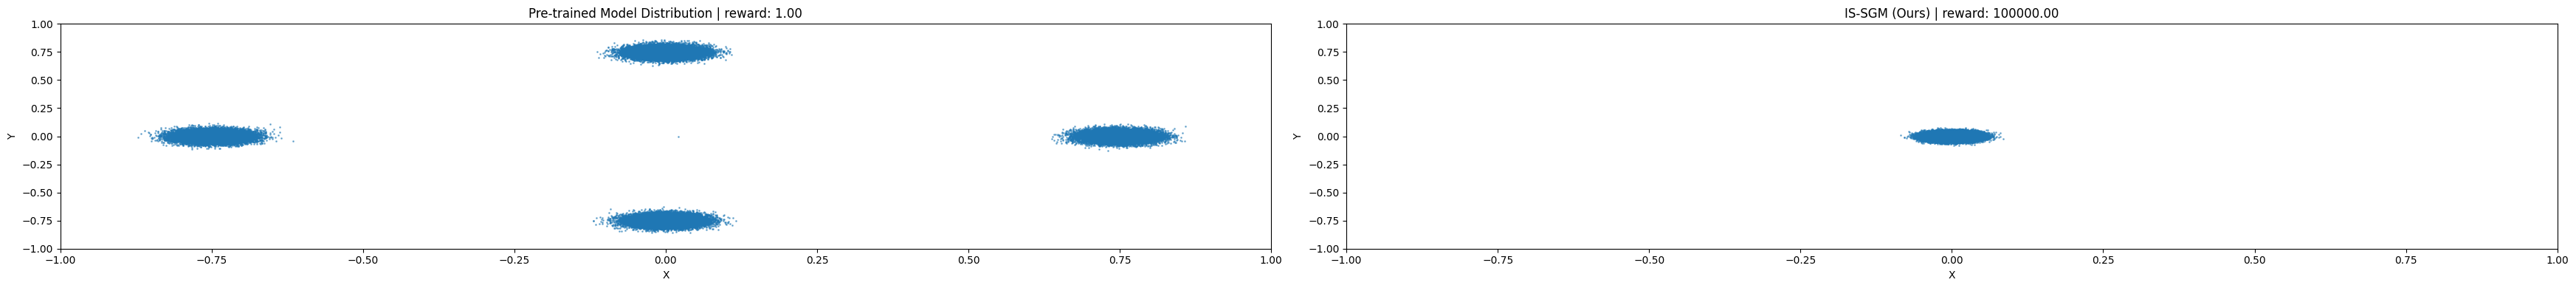

Figure saved as 'gaussian_mixture_1.png'


In [47]:
# Plot results
plt.figure(figsize=(35, 4))

# Set common axis limits
x_min, x_max = -1, 1
y_min, y_max = -1, 1


plt.subplot(1, 2, 1)
plt.scatter(base_samples[:, 0], base_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Base Distribution | reward: {base_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add the new SBIS subplot
plt.subplot(1, 2, 2)
plt.scatter(issgm_samples[:, 0], issgm_samples[:, 1], alpha=0.5, s=1)
plt.title(f'IS-SGM (Ours) | reward: {issgm_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()


# Save the figure
plt.savefig('gaussian_mixture_1.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

print("Figure saved as 'gaussian_mixture_1.png'")